In [1]:
import numpy as np
import pandas as pd

import graphviz
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

%matplotlib inline

import xgboost as xgb

from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.cross_validation import train_test_split

### Some initial observations:

1. Univariately, monotonic constraint = 1 works as expected
2. Univariately, monotonic constraint = -1 seems can only give constant predictions?
3. Adding monotonic constraint in Xgboost can potentially prevent overfitting

### Using the California housing dataset [1] to test Xgboost monotonicity constraint
[1] T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning Ed. 2”, Chapter 10.14,  Springer, 2009.

In [2]:
cal_housing = fetch_california_housing()
print cal_housing.feature_names, cal_housing.data.shape

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] (20640, 8)


In [3]:
# Training, validation, and hold-out testing dataset
X_train, X_valid_test, y_train, y_valid_test = train_test_split(cal_housing.data,
                                                                cal_housing.target,
                                                                test_size=0.5,
                                                                random_state=123)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size=0.5,
                                                    random_state=100)

In [4]:
features = ["MedInc"] 

feature_ids = [i for i, f in enumerate(cal_housing.feature_names) if f in features]
print feature_ids

[0]


In [5]:
dtrain = xgb.DMatrix(X_train[:, feature_ids], label = y_train)
dvalid = xgb.DMatrix(X_valid[:, feature_ids], label = y_valid)

In [6]:
params = {'max_depth': 2,
          'eta': 0.1,
          #'gamma': 0,
          #'min_child_weight': 10,
         }
params['silent'] = 1
params['nthread'] = 2
params['seed'] = 123
params['eval_metric'] = "rmse"

params_no_constr = params.copy()
params_constr = params.copy()

params_constr['updater'] = "grow_monotone_colmaker,prune"
params_constr['monotone_constraints'] = "(1)" 


evallist  = [(dtrain, 'train'), (dvalid, 'eval')]

bst_no_constr = xgb.train(params_no_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10)
bst_constr = xgb.train(params_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10)

[0]	train-rmse:1.78809	eval-rmse:1.79522
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.65154	eval-rmse:1.6579
[2]	train-rmse:1.53119	eval-rmse:1.5371
[3]	train-rmse:1.42623	eval-rmse:1.43138
[4]	train-rmse:1.33466	eval-rmse:1.33874
[5]	train-rmse:1.25515	eval-rmse:1.2591
[6]	train-rmse:1.18663	eval-rmse:1.19007
[7]	train-rmse:1.12782	eval-rmse:1.13122
[8]	train-rmse:1.07746	eval-rmse:1.08056
[9]	train-rmse:1.03468	eval-rmse:1.03707
[10]	train-rmse:0.998504	eval-rmse:1.00049
[11]	train-rmse:0.967908	eval-rmse:0.969473
[12]	train-rmse:0.942352	eval-rmse:0.943598
[13]	train-rmse:0.920951	eval-rmse:0.921835
[14]	train-rmse:0.903066	eval-rmse:0.90381
[15]	train-rmse:0.888235	eval-rmse:0.888738
[16]	train-rmse:0.875916	eval-rmse:0.876349
[17]	train-rmse:0.865783	eval-rmse:0.866005
[18]	train-rmse:0.857405	eval-rmse:0.857367
[19]	train-rmse:0.850487	eval-rmse:0.850292
[20]	train-r

In [7]:
def plot_one_feature_prediction(bst, X, y, f_id, title):

    """
    For one-feature model, plot data and prediction
    """
    
    x_scan = np.linspace(np.percentile(X[:, f_id], 0.1), np.percentile(X[:, f_id], 99.5), 50)
    dtest = xgb.DMatrix(x_scan.reshape((len(x_scan),1)))
    y_pred = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

    
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(x_scan, y_pred, color = 'black')
    ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)
        
    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_ylim(0, 5)
    
    feature_name = cal_housing.feature_names[f_id]
    ax.set_title(title)
    ax.set_xlabel(feature_name, fontsize = 10)
    ax.set_ylabel('Housing price', fontsize = 12)
    
    
def cal_rmse(y_test, y_pred):
    
    """
    Calculate root-mean-square error
    """
    
    square = (y_test - y_pred) ** 2
    
    return np.sqrt(np.mean(square))

### For single feature, monotonic constraint = 1 works as expected

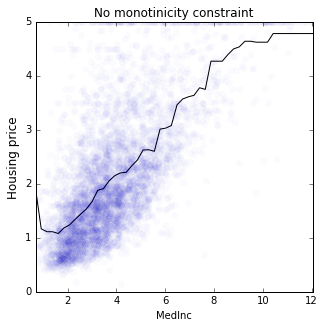

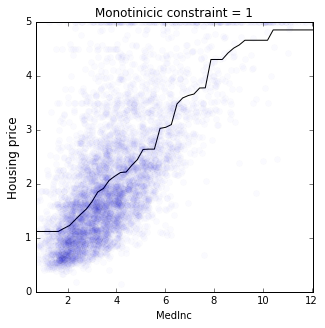

In [8]:
plot_one_feature_prediction(bst_no_constr, X_test, y_test, 0, "No monotinicity constraint")
plot_one_feature_prediction(bst_constr, X_test, y_test, 0, "Monotinicic constraint = 1")

### Applying monotonic constraint can potentially prevent overtraining and improve performance.

In [9]:
dtest = xgb.DMatrix(X_test[:, feature_ids])
y_pred_no_constr = bst_no_constr.predict(dtest, ntree_limit = bst_no_constr.best_ntree_limit)
y_pred_constr = bst_constr.predict(dtest, ntree_limit = bst_constr.best_ntree_limit)

print "No monotonicity constraint, testset RMSE: %.4f" % cal_rmse(y_test, y_pred_no_constr)
print "With monotonicity constraint, testset RMSE: %.4f" % cal_rmse(y_test, y_pred_constr)

No monotonicity constraint, testset RMSE: 0.8385
With monotonicity constraint, testset RMSE: 0.8375


### For single feature, testing monotonic constraint = -1

In [10]:
features = ["AveOccup"] 

feature_ids = [i for i, f in enumerate(cal_housing.feature_names) if f in features]
print feature_ids

[5]


In [11]:
dtrain = xgb.DMatrix(X_train[:, feature_ids], label = y_train)
dvalid = xgb.DMatrix(X_valid[:, feature_ids], label = y_valid)

In [12]:
params = {'max_depth': 2,
          'eta': 0.1,
          #'gamma': 0,
          #'min_child_weight': 10,
         }
params['silent'] = 1
params['nthread'] = 2
params['seed'] = 123
params['eval_metric'] = "rmse"

params_no_constr = params.copy()
params_constr = params.copy()

params_constr['updater'] = "grow_monotone_colmaker,prune"
params_constr['monotone_constraints'] = "(-1)" 


evallist  = [(dtrain, 'train'), (dvalid, 'eval')]

bst_no_constr = xgb.train(params_no_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10)
bst_constr = xgb.train(params_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10)

[0]	train-rmse:1.81396	eval-rmse:1.82276
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.70211	eval-rmse:1.71179
[2]	train-rmse:1.60569	eval-rmse:1.61612
[3]	train-rmse:1.52297	eval-rmse:1.53402
[4]	train-rmse:1.4525	eval-rmse:1.46396
[5]	train-rmse:1.39282	eval-rmse:1.40468
[6]	train-rmse:1.34245	eval-rmse:1.35478
[7]	train-rmse:1.30024	eval-rmse:1.31287
[8]	train-rmse:1.26494	eval-rmse:1.27792
[9]	train-rmse:1.23558	eval-rmse:1.24885
[10]	train-rmse:1.21128	eval-rmse:1.22476
[11]	train-rmse:1.19123	eval-rmse:1.20487
[12]	train-rmse:1.17468	eval-rmse:1.18848
[13]	train-rmse:1.16109	eval-rmse:1.17507
[14]	train-rmse:1.14997	eval-rmse:1.16405
[15]	train-rmse:1.14086	eval-rmse:1.15503
[16]	train-rmse:1.13337	eval-rmse:1.14778
[17]	train-rmse:1.12729	eval-rmse:1.14177
[18]	train-rmse:1.12228	eval-rmse:1.13705
[19]	train-rmse:1.1182	eval-rmse:1.13304
[20]	train-rmse:1.11489	eval-

### Monotonic constraint = -1 gives a constant prediction?

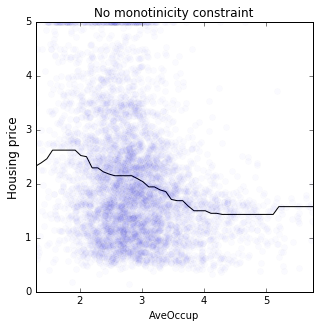

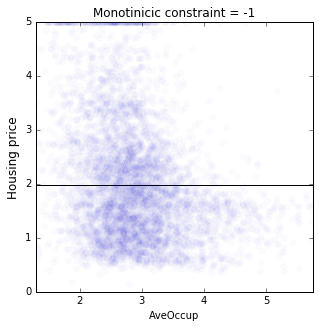

In [13]:
plot_one_feature_prediction(bst_no_constr, X_test, y_test, 5, "No monotinicity constraint")
plot_one_feature_prediction(bst_constr, X_test, y_test, 5, "Monotinicic constraint = -1")

### Further check the monotonic constraint = -1 by using just one tree with a single split

In [14]:
params = {'max_depth': 1,
          'eta': 0.1,
          #'gamma': 0,
          #'min_child_weight': 10,
         }
params['silent'] = 1
params['nthread'] = 2
params['seed'] = 123
params['eval_metric'] = "rmse"

params_no_constr = params.copy()
params_constr = params.copy()

params_constr['updater'] = "grow_monotone_colmaker,prune"
params_constr['monotone_constraints'] = "(-1)" 


evallist  = [(dtrain, 'train'), (dvalid, 'eval')]

bst_no_constr = xgb.train(params_no_constr, dtrain, num_boost_round = 1, evals = evallist)
bst_constr = xgb.train(params_constr, dtrain, num_boost_round = 1, evals = evallist)

[0]	train-rmse:1.81548	eval-rmse:1.82413
[0]	train-rmse:1.82652	eval-rmse:1.83513


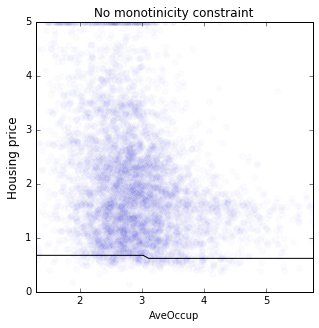

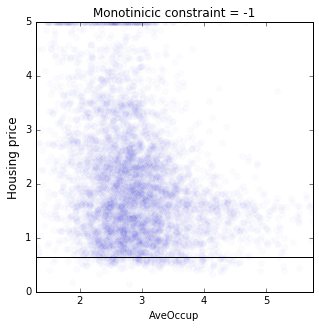

In [15]:
plot_one_feature_prediction(bst_no_constr, X_test, y_test, 5, "No monotinicity constraint")
plot_one_feature_prediction(bst_constr, X_test, y_test, 5, "Monotinicic constraint = -1")

No monotonic constraint


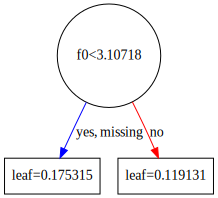

In [16]:
print "No monotonic constraint"
xgb.to_graphviz(bst_no_constr, num_trees=0)

Monotonic constraint = -1


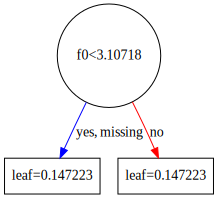

In [17]:
print "Monotonic constraint = -1"
xgb.to_graphviz(bst_constr, num_trees=0)